In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 

from PIL import Image

from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelBinarizer

In [373]:
device = torch.device('cuda')
device

device(type='cuda')

### Data preprocessing and visualisation

In [331]:
mnist_train_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
mnist_test_df = pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")

In [332]:
mnist_train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [333]:
label_binarizer = LabelBinarizer()

train_labels = mnist_train_df.label.values
# train_labels = label_binarizer.fit_transform(train_labels)

train_images = mnist_train_df.drop("label", axis=1).values.astype("float32")

test_labels = mnist_test_df.label.values
# test_labels = label_binarizer.fit_transform(test_labels)

test_images = mnist_test_df.drop("label", axis=1).values.astype("float32")

In [334]:
train_images = np.array([image.reshape((28, 28)) / np.linalg.norm(image) for image in train_images])

test_images = np.array([image.reshape((28, 28)) / np.linalg.norm(image) for image in test_images])

(28, 28)


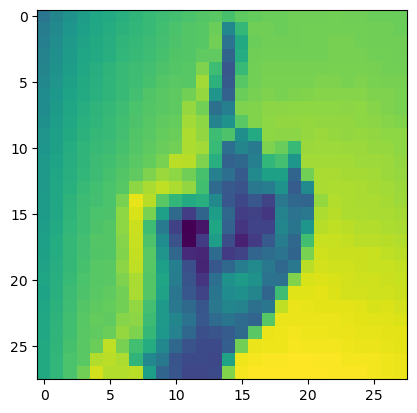

In [335]:
print(train_images[0].shape)
plt.imshow(train_images[0])

### Hyper parameters

In [336]:
BATCH_SIZE = 128
EPOCHS = 101
EPOCH_VALIDATION = 20
VALIDATION_DATA_RATIO = 0.1

CLASSES_NUM = 24
LABELS = np.unique(train_labels)

LEARNING_RATE = 0.001

In [337]:
LABELS

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

### Datasets & DataLoaders

In [338]:
class MNIST_Dataset(Dataset):
    def __init__(self, images: np.ndarray, labels: np.ndarray):
        self.images = images
        self.labels = labels
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Return index of label instead of the label itself
        image, label_index = self.images[idx], np.where(LABELS == self.labels[idx])[0]
        return image, label_index

In [339]:
train_dataset_size = (len(train_images) * (1 - VALIDATION_DATA_RATIO)).__floor__()

In [340]:
train_dataset = MNIST_Dataset(train_images[:train_dataset_size], train_labels[:train_dataset_size])
validation_dataset = MNIST_Dataset(train_images[train_dataset_size:], train_labels[train_dataset_size:])
test_dataset = MNIST_Dataset(test_images, test_labels)

In [341]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [342]:
next(train_dataloader._get_iterator())[1].shape

torch.Size([128, 1])

### Model architecture

In [343]:
class PantomimeModel(torch.nn.Module):
    def __init__(self):
        super(PantomimeModel, self).__init__()
        
        self.layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=75, kernel_size=(3, 3), stride=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=75),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=12675, out_features=CLASSES_NUM)
        )

    def forward(self, x):
        x = self.layers(x)
        
        # Distribute values between 0 and 1 
        x = torch.nn.functional.softmax(x, dim=1)

        return x

### Model train

In [377]:
def train(model: torch.nn.Module, train_dataloader: DataLoader, validation_dataloader: DataLoader, epochs: int, epoch_validation: int):
    for epoch in range(EPOCHS):
        
        model.train()
        
        epoch_true_class_indices, epoch_predicted_class_indices = np.array([]), np.array([])
        epoch_loss = 0.0
        
        for batch in train_dataloader:

            # Convert 2D images batch into 3D dimension with shape [batch_size=128, channels=1, height=28, width=28]
            images_batch, labels_batch = torch.unsqueeze(batch[0], dim=1).to(device), torch.flatten(batch[1]).to(device)
            
            optimizer.zero_grad()

            output = model(images_batch)
            
            loss = loss_fn(output, labels_batch)
            loss.backward()
            
            # Get image class index from each image prediction
            predicted_class_indices = torch.argmax(output, dim=1).cpu().detach().numpy()
                        
            # Add y_true
            epoch_true_class_indices = np.append(epoch_true_class_indices, labels_batch.cpu().detach().numpy())
            
            # Add y_pred
            epoch_predicted_class_indices = np.append(epoch_predicted_class_indices, predicted_class_indices)
            
            optimizer.step()
            epoch_loss += loss.item()
                    
        if epoch % epoch_validation == 0:
            
            model.eval()
            
            # Avverage the loss per batch
            epoch_loss /= BATCH_SIZE
            
            train_score = accuracy_score(y_true=epoch_true_class_indices, y_pred=epoch_predicted_class_indices)
                        
            validation_true_labels, validation_predicted_labels = np.array([]), np.array([])
            
            # Validation
            with torch.no_grad():
                
                for batch in validation_dataloader:

                    # Convert 2D images batch into 3D dimension with shape [batch_size=128, channels=1, height=28, width=28]
                    images_batch, labels_batch = torch.unsqueeze(batch[0], dim=1).to(device), torch.flatten(batch[1])
                    
                    output = model(images_batch)
            
                    # Get image class index from each image prediction
                    predicted_class_indices = torch.argmax(output, dim=1).cpu().detach().numpy()
                        
                    # Add y_true
                    validation_true_labels = np.append(validation_true_labels, labels_batch.cpu().detach().numpy())
            
                    # Add y_pred
                    validation_predicted_labels = np.append(validation_predicted_labels, predicted_class_indices)

                    validation_score = accuracy_score(y_true=validation_true_labels, y_pred=validation_predicted_labels)
            
            # Print epoch results
            print(f"EPOCH: {epoch} | epoch loss: {epoch_loss} | train accuracy score: {train_score} | validation accuracy score: {validation_score}")
            
            epoch_loss = 0.0

In [378]:
model = PantomimeModel().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
loss_fn = torch.nn.CrossEntropyLoss()

train(model, train_dataloader, validation_dataloader, EPOCHS, EPOCH_VALIDATION)

EPOCH: 0 | epoch loss: 3.72737324424088 | train accuracy score: 0.8025011129547938 | validation accuracy score: 0.887836853605244
EPOCH: 20 | epoch loss: 3.4697192534804344 | train accuracy score: 0.9580719575863046 | validation accuracy score: 0.9617625637290604
EPOCH: 40 | epoch loss: 3.41740719974041 | train accuracy score: 0.9923914363187503 | validation accuracy score: 0.9934450109249818
EPOCH: 60 | epoch loss: 3.4171699956059456 | train accuracy score: 0.992512849568983 | validation accuracy score: 0.9930808448652586
EPOCH: 80 | epoch loss: 3.4172072652727365 | train accuracy score: 0.992512849568983 | validation accuracy score: 0.9930808448652586
EPOCH: 100 | epoch loss: 3.4172079656273127 | train accuracy score: 0.992512849568983 | validation accuracy score: 0.9930808448652586
